<a href="https://colab.research.google.com/github/BZygierewicz/projekty/blob/main/pytorch_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn

In [141]:
# Ustawienie seedów dla powtarzalności wyników
torch.manual_seed(42)
np.random.seed(42)

# Wczytanie danych
data = sns.load_dataset("titanic")
print(data.head())
print("-------------")
print(data.info())
print("-------------")
print(data.describe())

   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived 

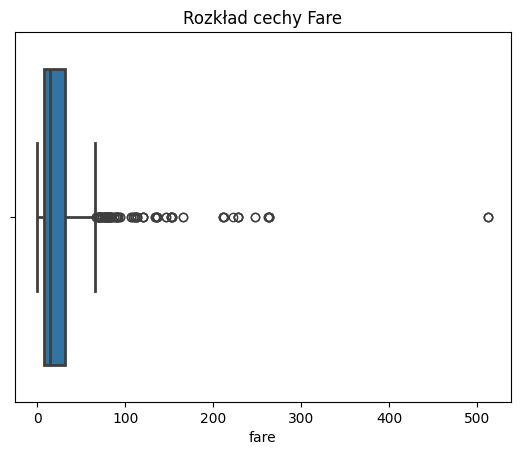

In [142]:
sns.boxplot(x="fare", data=data,linewidth=2)
plt.title("Rozkład cechy Fare")
plt.show()

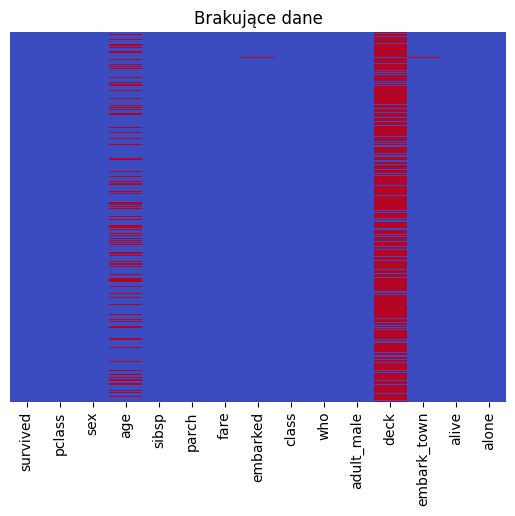

In [143]:
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='coolwarm')
plt.title("Brakujące dane")
plt.show()

In [144]:
def preprocess_data(data):
    data = data.copy()
    # Uzupełnienie braków
    data['age'] = data['age'].fillna(data['age'].mean())
    data['embarked'] = data['embarked'].fillna(data['embarked'].mode()[0])
    data['fare'] = data['fare'].fillna(data['fare'].median())
    # Kategoryczne na numeryczne
    data['sex'] = data['sex'].map({'male': 0, 'female': 1})
    data['embarked'] = data['embarked'].map({'S': 0, 'C': 1, 'Q': 2})
    # Nowa cecha
    data['family_size'] = data['sibsp'] + data['parch'] + 1
    # Usuwanie zbędnych kolumn
    data = data.drop(['who', 'embark_town', 'class', 'deck', 'alive'], axis=1)
    data.reset_index(drop=True, inplace=True)
    return data

In [145]:
data_processed = preprocess_data(data)

X = data_processed.drop('survived', axis=1)
y = data_processed['survived']

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Zbiór treningowy: {X_train.shape}, Zbiór testowy: {X_test.shape}")
print(f"Proporcje klas w y_train:\n{y_train.value_counts(normalize=True)}")
print(f"Proporcje klas w y_test:\n{y_test.value_counts(normalize=True)}")

Zbiór treningowy: (712, 10), Zbiór testowy: (179, 10)
Proporcje klas w y_train:
survived
0    0.616573
1    0.383427
Name: proportion, dtype: float64
Proporcje klas w y_test:
survived
0    0.614525
1    0.385475
Name: proportion, dtype: float64


In [146]:
# Skalowanie cech
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Konwersja do tensorów
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# DataLoader
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

In [147]:
class TitanicModel(nn.Module):
    def __init__(self, input_dim):
        super(TitanicModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.dropout = nn.Dropout(0.3)
        self.output = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.output(x))
        return x

input_dim = X_train_tensor.shape[1]
model = TitanicModel(input_dim)
print(model)

TitanicModel(
  (fc1): Linear(in_features=10, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (output): Linear(in_features=16, out_features=1, bias=True)
)


In [148]:
# Ustawienia treningu
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 200
losses = []

Epoch 10/200, Loss: 0.4513
Epoch 20/200, Loss: 0.4183
Epoch 30/200, Loss: 0.4197
Epoch 40/200, Loss: 0.4031
Epoch 50/200, Loss: 0.3830
Epoch 60/200, Loss: 0.3998
Epoch 70/200, Loss: 0.4000
Epoch 80/200, Loss: 0.3959
Epoch 90/200, Loss: 0.3822
Epoch 100/200, Loss: 0.3894
Epoch 110/200, Loss: 0.3972
Epoch 120/200, Loss: 0.3733
Epoch 130/200, Loss: 0.3853
Epoch 140/200, Loss: 0.3838
Epoch 150/200, Loss: 0.3680
Epoch 160/200, Loss: 0.3912
Epoch 170/200, Loss: 0.3752
Epoch 180/200, Loss: 0.3726
Epoch 190/200, Loss: 0.3606
Epoch 200/200, Loss: 0.3791


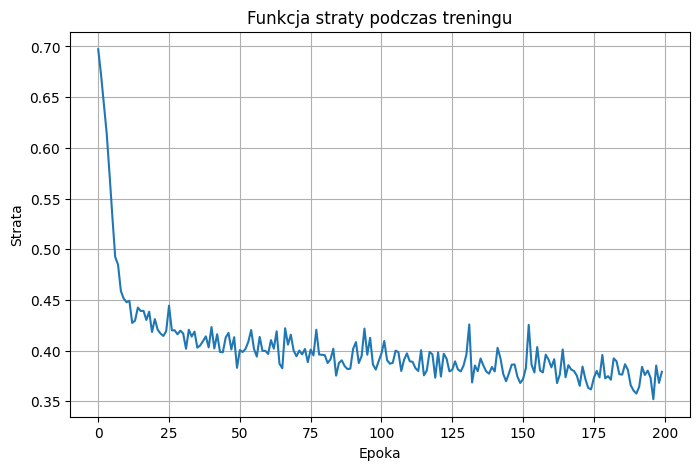

In [149]:
# Trening
model.train()
for epoch in range(epochs):
    epoch_loss = 0
    for batch_data, targets in train_dl:
        outputs = model(batch_data)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_dl)
    losses.append(avg_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

# Wizualizacja strat
plt.figure(figsize=(8,5))
plt.plot(losses)
plt.title('Funkcja straty podczas treningu')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.grid(True)
plt.show()


Macierz konfuzji:
[[101   9]
 [ 24  45]]

Raport klasyfikacji:
              precision    recall  f1-score   support

         0.0     0.8080    0.9182    0.8596       110
         1.0     0.8333    0.6522    0.7317        69

    accuracy                         0.8156       179
   macro avg     0.8207    0.7852    0.7956       179
weighted avg     0.8178    0.8156    0.8103       179


AUC-ROC: 0.8696


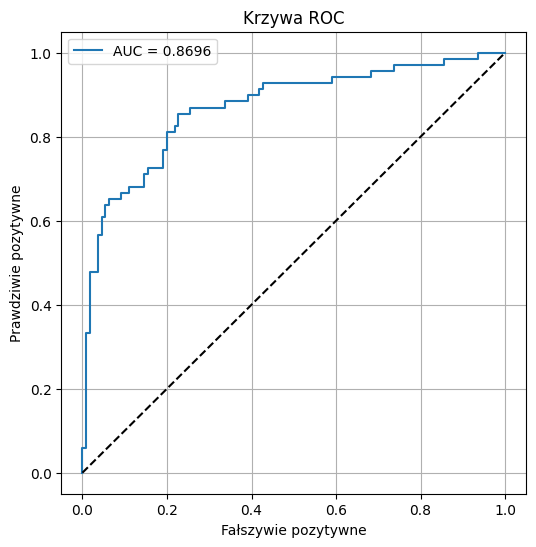

In [150]:
# Ewaluacja modelu
model.eval()
with torch.no_grad():
    preds = model(X_test_tensor)
    preds_class = (preds >= 0.5).int()

y_true_np = y_test_tensor.cpu().numpy()
y_pred_probs_np = preds.cpu().numpy().flatten()
y_pred_classes = preds_class.cpu().numpy()

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

cm = confusion_matrix(y_true_np, y_pred_classes)
print("Macierz konfuzji:")
print(cm)

print("\nRaport klasyfikacji:")
print(classification_report(y_true_np, y_pred_classes, digits=4))

auc = roc_auc_score(y_true_np, y_pred_probs_np)
print(f"\nAUC-ROC: {auc:.4f}")

fpr, tpr, _ = roc_curve(y_true_np, y_pred_probs_np)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('Fałszywie pozytywne')
plt.ylabel('Prawdziwie pozytywne')
plt.title('Krzywa ROC')
plt.legend()
plt.grid(True)
plt.show()